# FFF on 2d data

> Ways to represent space inside FFF

In [ ]:
#|default_exp tree

In [ ]:
#|hide
import nbdev
import math
import torch
import FastFF.imports.fff as fff
from FastFF.activations import *
import torchvision.transforms as T
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch import tensor
from torchvision.datasets import MNIST

In [ ]:
#|export
from fastai.vision.all import *
import matplotlib.colors as mcolors

In [ ]:
#|hide
set_seed(0)
n_cores = num_cpus()
device = default_device() # cuda or cpu

In [ ]:
#|export
def draw_line(x,y, ax = None, figsize=(5,3), **kwargs):
    if not ax: ax = subplots(figsize=figsize)[1][0]
    ax.plot(x,y, **kwargs)

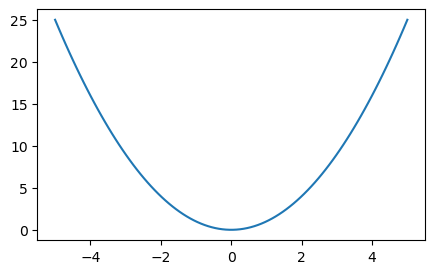

In [ ]:
x = np.linspace(-5.0,5, 100)
draw_line(x,x**2)

Now we will try to draw lines representing tree that FFF produces

In [ ]:
model_fff = fff.FFF(2, 3, 10, 2).to(device)
ws, biases = model_fff.node_weights.detach(), model_fff.node_biases.detach()

In [ ]:
def get_w_kernels(ws, bs, x1=torch.linspace(-10,10,100)):
    '''returns space of solutions to w1*x1+w2*x2+b=0 for each node. w1,w2 are projections of ws on first 2 dims'''
    x1 = to_device(x1, ws.device)
    w1, w2 = ws[:,0],ws[:,1]                        # (n_nodes,)
    x2 = (-bs - w1[...,None]*x1[None])/w2[...,None] # (n_nodes, 100)
    return x1,x2

In [ ]:
x1, x2 = get_w_kernels(ws,biases)
x1.shape, x2.shape

(torch.Size([100]), torch.Size([3, 100]))

## Tree traversal

To get mask for some node we have to get its turns (decisions) and intermediate nodes to get to this one.

For example
```txt
        0       to get to node 4,  
       / \      we have to visit nodes 0,1 and 4.
      1   2     And turns are [left, right] or [0,1]
     / \ / \
    3  4 5  6
```

In [ ]:
#|export
def idx_to_tree_path(idx: int):   # node index
    '''get turns and nodes of binary tree to reach `idx` node'''
    turns = list(map(int,[*bin(idx+1)[3:]]))
    nodes = reduce(lambda l,i: l+[l[-1]*2+2 if i else l[-1]*2+1], turns, [0])
    return turns, nodes

In [ ]:
test_eq(idx_to_tree_path(4), ([0,1],[0,1,4]))

In [ ]:
#|export
def get_mask(xb: Tensor,    # input tensor of shape (b_size, n_inp)
             idx: int,      # index of node
             ws: Tensor,    # model weights of shape (n_nodes, n_inp)
             bs: Tensor):   # model biases of shape (n_nodes,)
    '''get only points that end up at `idx` node'''
    assert idx <= ws.shape[0]*2, 'node in not in tree'
    xb = to_device(xb, ws.device)
    mask = torch.ones(xb.shape[0], device=ws.device).bool()
    ts, ns = idx_to_tree_path(idx)
    for t,v in zip(ts,ns[:-1]):
        m = (xb@ws[v]+bs[v]>0)
        if not t: m = ~m
        mask = mask & m
    return mask

In [ ]:
get_mask(torch.rand([20,2]),6, ws, biases)

tensor([False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False,  True, False, False, False, False],
       device='cuda:0')

In [ ]:
#|hide
def draw_tree_lines(ws,bs, x_lin = torch.linspace(-10,10,1000), ax=None, figsize=(6,4), cmap = 'plasma', **kwargs):
    if not ax: ax = subplots(figsize=figsize)[1][0]
    if not isinstance(cmap,mcolors.Colormap): cmap = plt.get_cmap(cmap)
    x1,x2 = get_w_kernels(ws,bs,x_lin) # (100,) (n_nodes,100)
    norm = mcolors.Normalize(vmin=0, vmax=x2.shape[0])
    for i,col in enumerate(cmap(norm(range(x2.shape[0])))):
        xb = torch.stack([x1, x2[i]],dim=1)
        mask = get_mask(xb,i,ws,bs)
        if not mask.any(): continue
        draw_line(*to_np([x1[mask],x2[i][mask]]), ax, color=col, label = i,**kwargs)
    ax.legend()

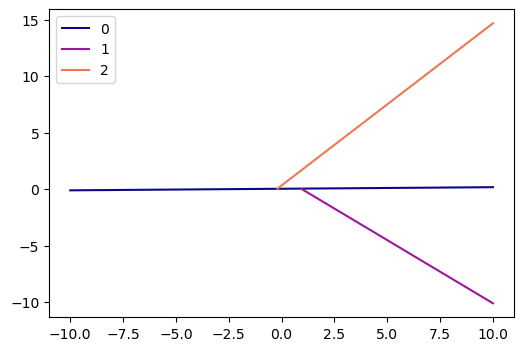

In [ ]:
draw_tree_lines(ws,biases)

# With model training

In [ ]:
#|export
def get_leaves(module, x_lim=(-10,10), n= 500):
    module.eval(); module.skip_out = True
    x_lin = torch.linspace(*x_lim, n)
    X, Y = torch.meshgrid(x_lin, x_lin, indexing='xy')
    xs = to_device(torch.stack([X,Y],dim=2).view(-1,X.shape[0],2), module.w1s.device)
    with torch.no_grad(): 
        Z = torch.stack([module(b) for b in xs]).view(X.shape)
    module.skip_out = False
    return X,Y,Z
    
def plot_contour(X,Y,Z, ax=None, cmap = 'plasma', figsize=(6,4), **kwargs):
    clev = torch.linspace(Z.min(),Z.max(),50)
    if not ax: ax = subplots(figsize=figsize)[1][0]
    if not isinstance(cmap,mcolors.Colormap): cmap = plt.get_cmap(cmap)
    ax.contourf(*to_np((X,Y,Z)), clev, cmap=cmap, **kwargs)

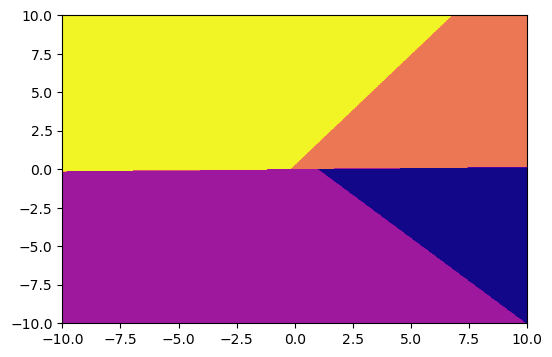

In [ ]:
plot_contour(*get_leaves(model_fff))

In [ ]:
#|export
class ContourCB(Callback):
    '''After each epoch calls `get_leaves` on all input space'''
    def __init__(self, module, x_lim=(-50,50), n=500): store_attr()
        
    def before_fit(self): self.z = []
    
    def after_epoch(self): 
        if not self.training:
            X,Y,Z = get_leaves(self.module, self.x_lim,self.n)
            if not hasattrs(self,('X','Y')): self.X,self.Y=X,Y
            self.z.append(Z)

    @delegates(plot_contour)
    def show(self, idx=-1, **kwargs):
        plot_contour(self.X,self.Y,self.z[idx],**kwargs)
    

In [ ]:
#|hide
#|eval: false
mean, std = 0.130652368068695068, 0.307504087686538696
bs = 256
tfm = T.Compose([T.ToTensor(),T.Normalize((mean,), (std,)),
                 T.Lambda(lambda x: x.view(-1,28*28).squeeze())])

train_dataset = MNIST('../data', train=True, download=True,transform=tfm)
test_dataset = MNIST('../data', train=False, download=True,transform=tfm)
dls = DataLoaders(TfmdDL(train_dataset, bs, True, n_cores),TfmdDL(test_dataset, bs, False, n_cores))

In [ ]:
model_fff = nn.Sequential(nn.Linear(28*28,64),
                          nn.ReLU(),
                          nn.Linear(64,2),
                          nn.ReLU(),
                          fff.FFF(2, 32, 10, 3, region_leak=0.3))
num_params(model_fff)

53800

epoch,train_loss,valid_loss,accuracy,time
0,1.402129,1.128051,0.593000,00:15
1,0.634728,0.838423,0.761800,00:15
2,0.395697,0.489629,0.877100,00:20
3,0.314164,0.569174,0.813400,00:16
4,0.268266,0.510081,0.863900,00:15
5,0.229101,1.117458,0.758100,00:15
6,0.204294,1.859467,0.664700,00:15
7,0.176981,0.679723,0.867400,00:15
8,0.153684,0.923860,0.727800,00:16
9,0.129124,1.684981,0.568200,00:34


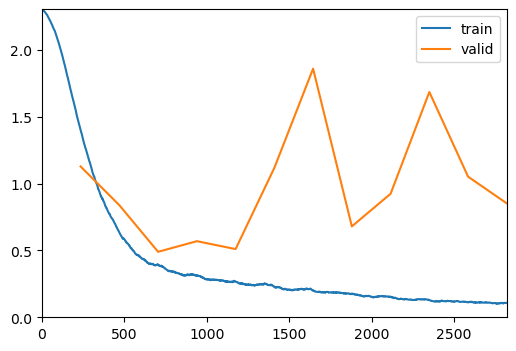

In [ ]:
#|eval: false
cntr = ContourCB(model_fff[-1],(-30,30))
cbs = [ShowGraphCallback(), cntr]
learn = Learner(dls, model_fff, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)
learn.fit_one_cycle(12, lr_max=0.7e-2)

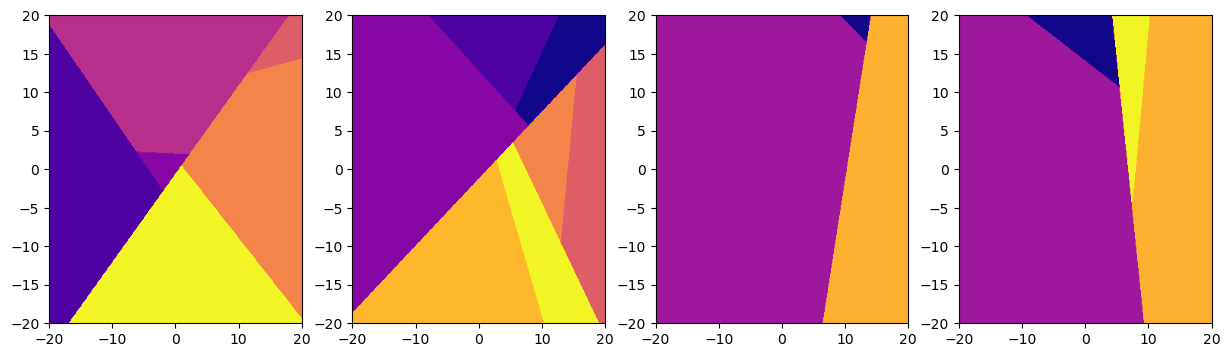

In [ ]:
#|eval: false
axes = subplots(ncols=4,figsize=(15,4))[1]
for i, ep in enumerate(range(0,12,3)):
    axes[i].set_ylim(-20,20); axes[i].set_xlim(-20,20)
    cntr.show(ep,ax=axes[i])

In [ ]:
#|eval: false
acts = [Activations2D(model_fff[2]), LeavesColors(model_fff[2],model_fff[-1])]
learn.get_preds(dl = dls.train, cbs=acts);

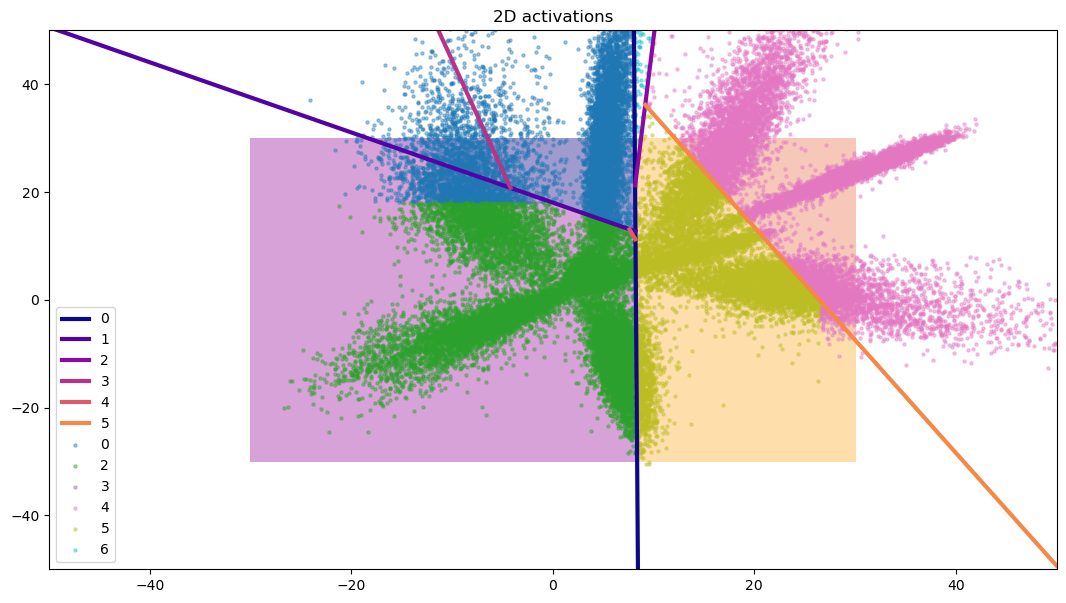

In [ ]:
#|eval: false
fff_mod = model_fff[-1]
ax = subplots(figsize=(13,7))[1][0]
cntr.show(ax=ax, alpha=0.4)
ax.set_ylim(-50,50); ax.set_xlim(-50,50)

draw_tree_lines(fff_mod.node_weights.detach(), fff_mod.node_biases.detach(), 
                 torch.linspace(-50,50,5000),ax=ax, linewidth=3, alpha=1)

#acts[0].show_acts(ax,alpha=0.4)
acts[1].show_acts(ax,alpha=0.4)

In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()